In [2]:
# Import Libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import operator

from sklearn.preprocessing import PolynomialFeatures
import scipy.optimize
RSEED=2

/Users/christinemerkel/.pyenv/versions/3.9.4/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
data = pd.read_csv('../data/GEFCom2014Data/Wind/raw_data.csv')
data.head()

,ZONEID,TIMESTAMP,TARGETVAR,U10,V10,U100,V100
0,1,20120101 1:00,0.000000,2.124600,-2.681966,2.864280,-3.666076
1,1,20120101 2:00,0.054879,2.521695,-1.796960,3.344859,-2.464761
2,1,20120101 3:00,0.110234,2.672210,-0.822516,3.508448,-1.214093
3,1,20120101 4:00,0.165116,2.457504,-0.143642,3.215233,-0.355546
4,1,20120101 5:00,0.156940,2.245898,0.389576,2.957678,0.332701


In [4]:
data['WS100'] = np.sqrt(data['U100']**2 + data['V100']**2)
data['WS10'] = np.sqrt(data['U10']**2 + data['V10']**2)
data['WDIR100'] = data.apply(lambda x: ((180. + 180./np.pi * math.atan2(x['U100'],x['V100'])) % 360),axis=1)
data['WDIR10'] = data.apply(lambda x: ((180. + 180./np.pi * math.atan2(x['U10'],x['V10'])) % 360),axis=1)

data.head()

,ZONEID,TIMESTAMP,TARGETVAR,U10,V10,U100,V100,WS100,WS10,WDIR100,WDIR10
0,1,20120101 1:00,0.000000,2.124600,-2.681966,2.864280,-3.666076,4.652334,3.421530,321.999735,321.614439
1,1,20120101 2:00,0.054879,2.521695,-1.796960,3.344859,-2.464761,4.154892,3.096451,306.385781,305.473680
2,1,20120101 3:00,0.110234,2.672210,-0.822516,3.508448,-1.214093,3.712577,2.795932,289.088098,287.108562
3,1,20120101 4:00,0.165116,2.457504,-0.143642,3.215233,-0.355546,3.234831,2.461699,276.310236,273.345160
4,1,20120101 5:00,0.156940,2.245898,0.389576,2.957678,0.332701,2.976332,2.279435,263.581938,260.159324


In [5]:
data_12_ = data.copy()
data_12_.TIMESTAMP.min()
data_12_ = data_12_[data_12_['TIMESTAMP'] < '20130101 10:00']
data_12_.tail()


,ZONEID,TIMESTAMP,TARGETVAR,U10,V10,U100,V100,WS100,WS10,WDIR100,WDIR10
159979,10,20121231 20:00,0.248483,-2.197067,1.971691,-3.891828,3.131582,4.995310,2.952062,128.822097,131.905421
159980,10,20121231 21:00,0.161243,-2.159160,2.201728,-3.364028,3.132070,4.596363,3.083761,132.954991,135.559273
159981,10,20121231 22:00,0.102605,-1.761334,1.848040,-2.454366,2.533016,3.527049,2.552950,135.903468,136.376120
159982,10,20121231 23:00,0.004978,-1.450097,1.679025,-1.756795,2.059049,2.706661,2.218537,139.528954,139.184333
159983,10,20130101 0:00,0.000000,-0.759788,1.487126,-0.785353,1.784441,1.949618,1.669976,156.245159,152.937049


In [6]:
data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP']).dt.date

In [7]:
data.head()

,ZONEID,TIMESTAMP,TARGETVAR,U10,V10,U100,V100,WS100,WS10,WDIR100,WDIR10
0,1,2012-01-01,0.000000,2.124600,-2.681966,2.864280,-3.666076,4.652334,3.421530,321.999735,321.614439
1,1,2012-01-01,0.054879,2.521695,-1.796960,3.344859,-2.464761,4.154892,3.096451,306.385781,305.473680
2,1,2012-01-01,0.110234,2.672210,-0.822516,3.508448,-1.214093,3.712577,2.795932,289.088098,287.108562
3,1,2012-01-01,0.165116,2.457504,-0.143642,3.215233,-0.355546,3.234831,2.461699,276.310236,273.345160
4,1,2012-01-01,0.156940,2.245898,0.389576,2.957678,0.332701,2.976332,2.279435,263.581938,260.159324


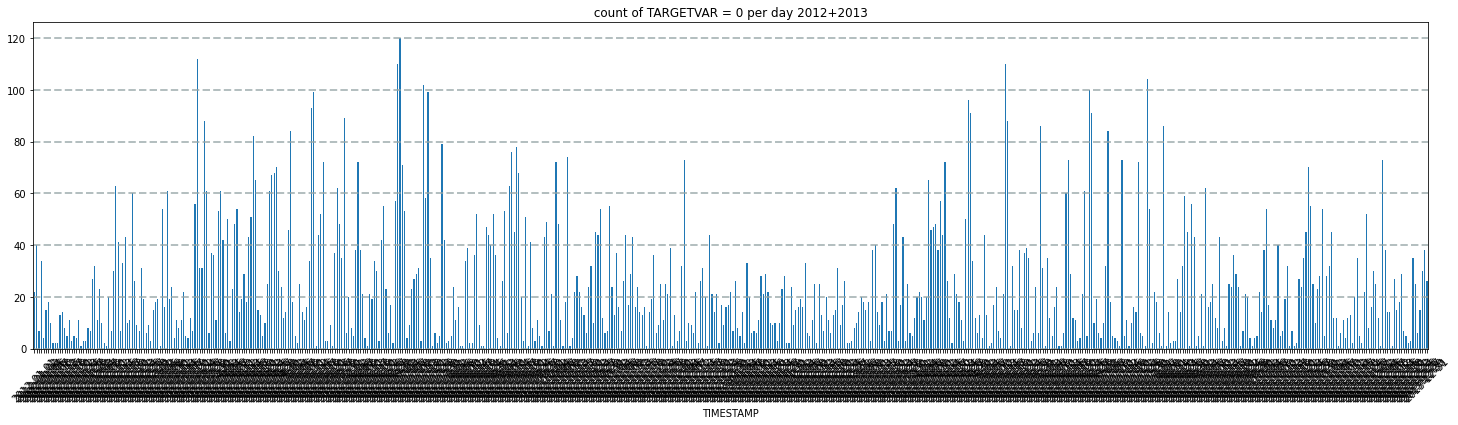

In [8]:
d = data.query('TARGETVAR == 0')
plt.figure(figsize = (25,6))
d.groupby('TIMESTAMP').TARGETVAR.count().plot(kind = 'bar')
plt.title(" count of TARGETVAR = 0 per day 2012+2013 ")
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.xticks(rotation = 45);

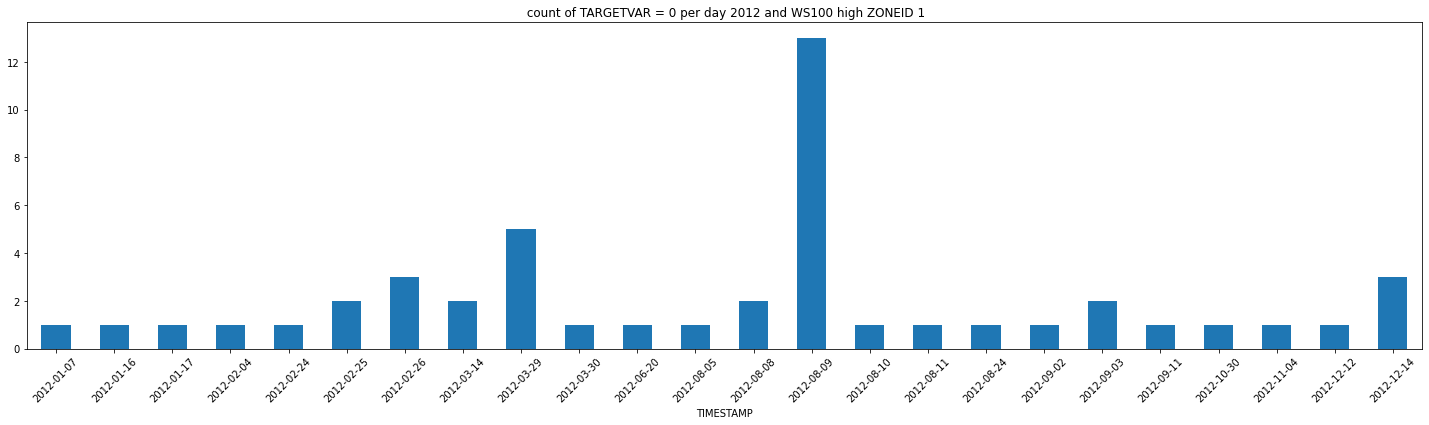

In [9]:
data_12_['TIMESTAMP'] = pd.to_datetime(data_12_['TIMESTAMP']).dt.date
#d12 = data_12_.query('(TARGETVAR == 0) and (U100 > U100.mean())')
#d12 = data_12_.query('TARGETVAR == 0')
d12 = data_12_.query('(TARGETVAR == 0) and (WS100 > WS100.mean()) and (ZONEID==1)')
plt.figure(figsize = (25,6))
d12.groupby('TIMESTAMP').TARGETVAR.count().plot(kind = 'bar')
plt.title(" count of TARGETVAR = 0 per day 2012 and WS100 high ZONEID 1")
plt.xticks(rotation = 45);

In [10]:
data.U100.mean()

1.2727693619836458

In [11]:
data.dropna(inplace=True)

In [12]:
data.head()

,ZONEID,TIMESTAMP,TARGETVAR,U10,V10,U100,V100,WS100,WS10,WDIR100,WDIR10
0,1,2012-01-01,0.000000,2.124600,-2.681966,2.864280,-3.666076,4.652334,3.421530,321.999735,321.614439
1,1,2012-01-01,0.054879,2.521695,-1.796960,3.344859,-2.464761,4.154892,3.096451,306.385781,305.473680
2,1,2012-01-01,0.110234,2.672210,-0.822516,3.508448,-1.214093,3.712577,2.795932,289.088098,287.108562
3,1,2012-01-01,0.165116,2.457504,-0.143642,3.215233,-0.355546,3.234831,2.461699,276.310236,273.345160
4,1,2012-01-01,0.156940,2.245898,0.389576,2.957678,0.332701,2.976332,2.279435,263.581938,260.159324


In [13]:

#df_drop_zeroes = data.drop(data[data.TARGETVAR == 0].index)
df_drop_zeroes = data[data.TARGETVAR !=0]

In [14]:
(df_drop_zeroes==0).sum()

ZONEID       0
TIMESTAMP    0
TARGETVAR    0
U10          0
V10          0
U100         0
V100         0
WS100        0
WS10         0
WDIR100      0
WDIR10       0
dtype: int64

In [15]:
#df_drop_zeroes.loc[df_drop_zeroes['TARGETVAR'] < 0.1, 'TARGETVAR'] = 0

In [16]:
# define feature and target
X = df_drop_zeroes[["WS100"]]
y = df_drop_zeroes.TARGETVAR

In [17]:
y.min()

8.60457699133703e-08

In [18]:
# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RSEED, shuffle=True)

In [19]:
np.isnan(y_train).sum()

0

In [20]:
y_train.mean()

0.3893581349508464

In [21]:
np.ones(len(y_test))*y_train.mean()

array([0.38935813, 0.38935813, 0.38935813, ..., 0.38935813, 0.38935813,
       0.38935813])

In [22]:
# Fit a basic linear regression model on the train data
lm = LinearRegression()
lm.fit(X_train, y_train)

# make predictions on test data
y_pred = lm.predict(X_test)

# evaluation metrics test
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False)}")
print(np.mean(y_pred-y_test))

RMSE: 0.20101035409833143
-0.001269960066660189


In [23]:
print(f"RMSE: {mean_squared_error(y_test,np.ones(len(y_test))*y_train.mean() , squared=False)}")

RMSE: 0.30471526492551493


In [24]:
df_drop_zeroes.head()

,ZONEID,TIMESTAMP,TARGETVAR,U10,V10,U100,V100,WS100,WS10,WDIR100,WDIR10
1,1,2012-01-01,0.054879,2.521695,-1.796960,3.344859,-2.464761,4.154892,3.096451,306.385781,305.473680
2,1,2012-01-01,0.110234,2.672210,-0.822516,3.508448,-1.214093,3.712577,2.795932,289.088098,287.108562
3,1,2012-01-01,0.165116,2.457504,-0.143642,3.215233,-0.355546,3.234831,2.461699,276.310236,273.345160
4,1,2012-01-01,0.156940,2.245898,0.389576,2.957678,0.332701,2.976332,2.279435,263.581938,260.159324
5,1,2012-01-01,0.168781,1.986038,0.796304,2.655406,0.882648,2.798258,2.139730,251.613368,248.151622


In [25]:
cols = ['U10', 'V10', 'U100', 'V100', 'WS100', 'WS10', 'WDIR100', 'WDIR10']
for col in cols:
    X = df_drop_zeroes[[col]]
    y = df_drop_zeroes.TARGETVAR
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RSEED, shuffle=True)
    lm = LinearRegression()
    lm.fit(X_train, y_train)

    # make predictions on test data
    y_pred = lm.predict(X_test)

    # evaluation metrics test
    print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False)}"+' -> '+ col)
    #print(np.mean(y_pred-y_test))

X = df_drop_zeroes[['U100', 'WDIR100']]
y = df_drop_zeroes.TARGETVAR
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RSEED, shuffle=True)
lm = LinearRegression()
lm.fit(X_train, y_train)

# make predictions on test data
y_pred = lm.predict(X_test)

# evaluation metrics test
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False)}"+ ' -> U100 + WDIR100')
#print(np.mean(y_pred-y_test))   
    

RMSE: 0.294976997590432 -> U10
RMSE: 0.3021978443144588 -> V10
RMSE: 0.2954432023758919 -> U100
RMSE: 0.30174899122616383 -> V100
RMSE: 0.20101035409833143 -> WS100
RMSE: 0.21993969236676844 -> WS10
RMSE: 0.302233559791192 -> WDIR100
RMSE: 0.3024698933321028 -> WDIR10
RMSE: 0.29485791240706494 -> U100 + WDIR100


In [66]:
cols = ['U10', 'V10', 'U100', 'V100', 'WS100', 'WS10', 'WDIR100', 'WDIR10']
for col in cols:
    X = df_drop_zeroes[[col]]
    y = df_drop_zeroes.TARGETVAR
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True)

    
    # here we will add the second degree polynomial features
    polynomial_features = PolynomialFeatures(degree=2)
    x_poly = polynomial_features.fit_transform(X_train)


    model_poly = LinearRegression()
    model_poly.fit(x_poly, y_train)
    y_poly_pred = model_poly.predict(x_poly)

    print(col)
    print(f"RMSE: {mean_squared_error(y_test, y_poly_pred, squared=False)}")
    
    

U10


ValueError: Found input variables with inconsistent numbers of samples: [40290, 120867]

In [54]:
X = np.array(df_drop_zeroes[['WS100']].head(1000))
y = np.array(df_drop_zeroes.TARGETVAR.head(1000))

y

array([5.48791197e-02, 1.10233998e-01, 1.65116056e-01, 1.56940134e-01,
       1.68781126e-01, 1.14744854e-01, 8.54243023e-02, 1.53181091e-01,
       1.39272625e-01, 8.38267062e-02, 1.47824450e-01, 1.38708763e-01,
       2.22065590e-01, 2.41048769e-01, 2.45841550e-01, 2.39075273e-01,
       2.53453620e-01, 3.02039275e-01, 5.16022917e-01, 7.35457175e-01,
       6.18926787e-01, 8.15430868e-01, 7.60454834e-01, 4.39244421e-01,
       2.05807719e-01, 1.90019729e-01, 8.03495886e-01, 7.55004215e-01,
       3.76750294e-01, 5.67803766e-01, 2.74222341e-01, 1.54684708e-01,
       9.52917945e-02, 8.74917750e-02, 2.39521636e-02, 1.95294225e-03,
       5.94868902e-02, 2.38670004e-02, 3.05246226e-02, 5.71374860e-02,
       3.36434538e-02, 1.06104919e-02, 1.91617324e-01, 3.92726241e-01,
       2.79485010e-01, 1.29217178e-01, 1.17658111e-01, 1.87388399e-01,
       2.09096886e-01, 1.90395639e-01, 1.50831684e-01, 1.32882246e-01,
       1.92181183e-01, 2.40390935e-01, 3.41979128e-01, 5.45343470e-01,
      

In [56]:
def sigmoid(p,x): 
    x0,y0,c,k=p 
    y = c / (1 + np.exp(-k*(x-x0))) + y0 
    return y.ravel() 

def residuals(p,x,y): 
    return y - sigmoid(p,x) 



In [57]:
sigmoid((1,1,1,0.01) , X)

array([1.50788658, 1.50678103, 1.50558685, 1.50494067, 1.50449552,
       1.50437303, 1.50832495, 1.5144133 , 1.5136107 , 1.51403764,
       1.51322916, 1.51196375, 1.51167497, 1.51125889, 1.51226421,
       1.51679134, 1.51965134, 1.52019142, 1.51947732, 1.51817096,
       1.51747323, 1.51691545, 1.51752271, 1.52118764, 1.52170032,
       1.52122224, 1.52080042, 1.52052527, 1.51815101, 1.51796108,
       1.51610962, 1.51564217, 1.51348121, 1.51438863, 1.51110953,
       1.50963801, 1.50754036, 1.50522197, 1.50774304, 1.50426099,
       1.50210687, 1.50059745, 1.50615432, 1.50349345, 1.5097841 ,
       1.51593961, 1.5163589 , 1.51673281, 1.51603135, 1.51475871,
       1.51252991, 1.51033471, 1.50652989, 1.50937631, 1.51628416,
       1.51857217, 1.51896215, 1.51562604, 1.51579361, 1.51795139,
       1.5192779 , 1.51626626, 1.51752154, 1.5175452 , 1.51703429,
       1.51581083, 1.51683232, 1.51679335, 1.51546919, 1.51439558,
       1.51436258, 1.51401987, 1.51347649, 1.51310644, 1.51341

In [58]:
residuals( (1,1,1,0.01) , X, y)

array([-1.45300746, -1.39654703, -1.34047079, -1.34800053, -1.3357144 ,
       -1.38962817, -1.42290065, -1.36123221, -1.37433808, -1.43021094,
       -1.36540471, -1.37325499, -1.28960938, -1.27021012, -1.26642266,
       -1.27771607, -1.26619772, -1.21815215, -1.0034544 , -0.78271379,
       -0.89854644, -0.70148458, -0.75706787, -1.08194322, -1.3158926 ,
       -1.33120251, -0.71730453, -0.76552105, -1.14140072, -0.95015732,
       -1.24188728, -1.36095746, -1.41818941, -1.42689685, -1.48715737,
       -1.50768507, -1.44805347, -1.48135497, -1.47721842, -1.4471235 ,
       -1.46846342, -1.48998696, -1.314537  , -1.11076721, -1.23029909,
       -1.38672244, -1.39870079, -1.32934441, -1.30693447, -1.32436307,
       -1.36169822, -1.37745246, -1.31434871, -1.26898538, -1.17430503,
       -0.9732287 , -0.75907119, -0.68732043, -0.80129311, -0.76482669,
       -0.82235093, -0.79311995, -0.92152494, -1.10846712, -1.23811314,
       -1.23341257, -1.19797132, -1.24670596, -1.26981559, -1.28

In [62]:
p_guess=(10,1,0.1,0.01) 
p, cov, infodict,  mesg,  ier=scipy.optimize.leastsq(residuals,p_guess,args=(X,y),full_output=1) #,warning=True)  


/var/folders/ml/wvx29l8j6h1gp24y92jgbnvw0000gn/T/ipykernel_17876/1169404899.py:3: RuntimeWarning: overflow encountered in exp
  y = c / (1 + np.exp(-k*(x-x0))) + y0


In [63]:
x0,y0,c,k=p
print('''\
x0 = {x0}
y0 = {y0}
c = {c}
k = {k}
'''.format(x0=x0,y0=y0,c=c,k=k))

x0 = 1029.261108745067
y0 = 0.35270133828686
c = -0.11148960561168747
k = 2.711699421158219



/var/folders/ml/wvx29l8j6h1gp24y92jgbnvw0000gn/T/ipykernel_17876/1169404899.py:3: RuntimeWarning: overflow encountered in exp
  y = c / (1 + np.exp(-k*(x-x0))) + y0


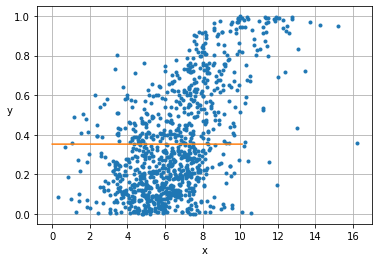

In [64]:
xp = np.linspace(0, 10.1, 1500)
pxp=sigmoid(p,xp)

# Plot the results
plt.plot(X, y, '.', xp, pxp, '-')
plt.xlabel('x')
plt.ylabel('y',rotation='horizontal') 
plt.grid(True)
plt.show()